#Food Delivery Time Prediction

In [ ]:
#Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from geopy.distance import geodesic
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


##Phase 1: Data Collection and Exploratory Data Analysis (EDA)

###Step 1 - Data Import and Preprocessing

In [ ]:
#Load the DataSet
df = pd.read_csv("Food_Delivery_Time_Prediction.csv")
df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [ ]:
#Handle Missing Values

print(df.isnull().sum())

Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64


In [ ]:
# Encode Categorical Variables
for col in ['Weather_Conditions', 'Traffic_Conditions', 'Vehicle_Type']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Normalize Numeric Features
scaler = StandardScaler()
numeric_cols = ['Distance', 'Delivery_Time', 'Order_Cost']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

###Step 2 - Exploratory Data Analysis (EDA)

           Distance  Weather_Conditions  Traffic_Conditions  \
count  2.000000e+02          200.000000          200.000000   
mean  -1.643130e-16            1.560000            1.085000   
std    1.002509e+00            1.096546            0.768589   
min   -1.608593e+00            0.000000            0.000000   
25%   -7.924313e-01            1.000000            0.000000   
50%   -1.806765e-01            2.000000            1.000000   
75%    7.325599e-01            3.000000            2.000000   
max    1.963762e+00            3.000000            2.000000   

       Delivery_Person_Experience  Vehicle_Type  Restaurant_Rating  \
count                  200.000000    200.000000         200.000000   
mean                     5.250000      0.965000           3.738500   
std                      2.745027      0.810593           0.703021   
min                      1.000000      0.000000           2.500000   
25%                      3.000000      0.000000           3.200000   
50%         

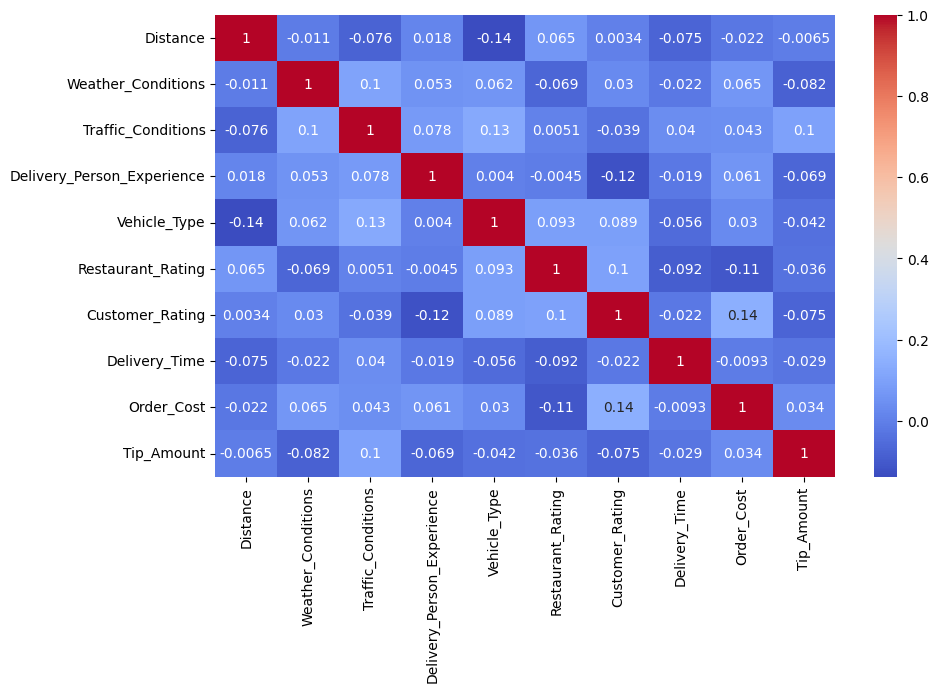

<Axes: xlabel='Delivery_Time'>

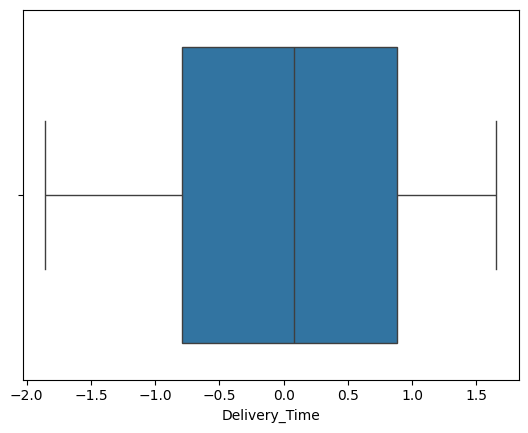

In [ ]:
#Descriptive Statistics
print(df.describe())

#Correlation Analysis
numeric_df = df.select_dtypes(include='number')
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.show()

#Outlier Detection
sns.boxplot(x = df['Delivery_Time'])

###Step 3 - Feature Engineering

In [ ]:
#Distance Calculation


#Convert string tuples into latitude and longitude
df["Rest_Lat"], df["Rest_Long"] = zip(*df["Restaurant_Location"].apply(eval))
df["Cust_Lat"], df["Cust_Long"] = zip(*df["Customer_Location"].apply(eval))

#Calculate distance
df["Distance"] = df.apply(lambda x: geodesic((x["Rest_Lat"], x["Rest_Long"]),
                                             (x["Cust_Lat"], x["Cust_Long"])).km, axis=1)

#Time-Based Features
df["Rush_Hour"] = df["Order_Time"].apply(lambda x: 1 if x in range(17, 20) else 0)


##Phase 2: Predictive Modeling

###Step 4 - Linear Regression Model

In [ ]:

# Check for categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Apply Label Encoding to all categorical columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

#  # Drop irrelevant columns (if needed)
X = df.drop(columns=['Delivery_Time', 'Customer_Location', 'Restaurant_Location'])

# Define target variable
y = df['Delivery_Time']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model building
model = LinearRegression()
model.fit(X_train, y_train)

#Evaluation Metrics
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


MSE: 0.9557924638482256
R² Score: 0.08499650253214308
MAE: 0.8370425158964092


###Step 5 - Logistic Regression Model (for Categorization)

In [ ]:
#Model Objective
threshold = df['Delivery_Time'].median()
print(f"New Threshold: {threshold}")

threshold = df['Delivery_Time'].median()  # Automatically determine a balanced threshold

df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 'Fast' if x <= threshold else 'Delayed')

df['Delivery_Status'] = df['Delivery_Status'].map({'Fast': 0, 'Delayed': 1})

# print(y_train.value_counts(), y_test.value_counts())
print(df['Delivery_Status'].value_counts())

#Model Implementation
X = df.drop(columns=['Delivery_Status', 'Order_ID', 'Order_Time'])
y = df['Delivery_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


model = LogisticRegression()
model.fit(X_train , y_train)
y_pred = model.predict(X_test)

#Evaluatation Metrices


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



New Threshold: 0.07662482028384994
Delivery_Status
0    100
1    100
Name: count, dtype: int64
Accuracy: 0.9666666666666667
Precision: 0.9375
Recall: 1.0
F1 Score: 0.967741935483871
Confusion Matrix:
 [[28  2]
 [ 0 30]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
